# Recommendation system

download dataset [Health_and_Personal_Care.jsonl.gz](https://drive.google.com/file/d/12N52kB4D1iqgzSuoWEfNSY3KqVRp10wL/view?usp=drive_link)

put in to `data` dir

In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os

import numpy as np

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

run_env = os.getenv('RUN_ENV', 'COLLAB')
if run_env == 'COLLAB':
  from google.colab import drive
  ROOT_DIR = '/content/drive'
  drive.mount(ROOT_DIR)
  print('Google drive connected')
  DRIVE_DATA_DIR = 'ml_course_data'
  root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', DRIVE_DATA_DIR)
  sys.path.append(os.path.join(ROOT_DIR, 'MyDrive', 'src'))
else:
  root_data_dir = os.getenv('DATA_DIR', '/srv/data')

if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  print('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir)[:5])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Содержимое директории %s: %s /Users/adzhumurat/PycharmProjects/ai_product_engineer/data ['client_segmentation.csv', 'messages.db', 'labeled_data_corpus.csv', 'content_description.csv', 'nltk_data']


In [4]:
from utils import read_raw_data

file_name = 'Health_and_Personal_Care.jsonl.gz'
data_path = os.path.join(root_data_dir, file_name)

json_data = read_raw_data(data_path, limit=1000)
print(len(json_data))

Dataset num items: 1000 from /Users/adzhumurat/PycharmProjects/ai_product_engineer/data/Health_and_Personal_Care.jsonl.gz
1000


In [5]:
json_data[0]

{'rating': 4.0,
 'title': '12 mg is 12 on the periodic table people! Mg for magnesium',
 'text': 'This review is more to clarify someone else’s review bc they didn’t understand understand the labeling!  It shows 1000mg as advertised & another little label says 12mg bc 12 is on the periodic table for magnesium!  I realize not everyone takes chemistry, but 4 ppl liked his review & so misinformation is spreading.  This works. If however you are on opiate level medications that are causing constipation you should talk to your pain dr or your gastrointestinal dr & ask for a medication called Linzess which works must better & must faster, but is unnecessary for most people.  If magnesium is working for you just make sure to take it with food & drink 6-8 glasses of water per day.  Staying hydrated will really help.  Before switching to Linzess I used to take one 1,000 mg pill am & pm every day with meals & always with an 8 ounce glass of water or other liquid.',
 'images': [],
 'asin': 'B07TD

In [6]:
import pandas as pd

user_item_data_df = pd.DataFrame([('health', i['user_id'], i['parent_asin'], i['rating']) for i in json_data], columns=['category', 'CustomerID', 'ProductID', 'target'])

user_item_data_df.head()

,category,CustomerID,ProductID,target
0,health,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B07TDSJZMR,4.0
1,health,AEVWAM3YWN5URJVJIZZ6XPD2MKIA,B08637FWWF,5.0
2,health,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,B07KJVGNN5,5.0
3,health,AEZGPLOYTSAPR3DHZKKXEFPAXUAA,B092RP73CX,4.0
4,health,AEQAYV7RXZEBXMQIQPL6KCT2CFWQ,B08KYJLF5T,1.0


Recommender baseline

In [7]:
popularity_df = (
    user_item_data_df
    .groupby('ProductID')
    .agg(num_entries=('CustomerID', 'count'))
    .sort_values(by='num_entries', ascending=False)
)

popularity_df.head()

,num_entries
ProductID,
B07XVVVB8W,22
B08X9LB1WC,7
B0BSRPX53Z,7
B0B4328BFW,5
B08KBQNDJC,4


In [15]:
from recsys.utils import prepare_evaluation_df

evaluation_df = prepare_evaluation_df(user_item_data_df).to_pandas()
print(evaluation_df['target'].value_counts().to_dict())
evaluation_df.head()

Transformation started...
Negative candidates: 380264, Positive samples: 1000
Num negatives 0.6702412868632708
{0: 2000, 1: 984}


,category,CustomerID,ProductID,target
0,health,AE25NQAZI3725GZIL5FS52ZIKWKQ,B007QESMDK,1
1,health,AE25NQAZI3725GZIL5FS52ZIKWKQ,B0BLGM5PDZ,0
2,health,AE25NQAZI3725GZIL5FS52ZIKWKQ,B086MFCTZN,0
3,health,AE25NQAZI3725GZIL5FS52ZIKWKQ,B074SPZRMM,0
4,health,AE25NQAZI3725GZIL5FS52ZIKWKQ,B00VF8DNUA,0


# Features

prepare sparse features

In [9]:
file_name = 'meta_Health_and_Personal_Care.jsonl.gz'
data_path = os.path.join(root_data_dir, file_name)

json_meta_data = [i for i in read_raw_data(data_path) if i['parent_asin'] in user_item_data_df['ProductID'].values]
print(len(json_meta_data))

Dataset num items: 60293 from /Users/adzhumurat/PycharmProjects/ai_product_engineer/data/meta_Health_and_Personal_Care.jsonl.gz
851


In [10]:
catalog_df = pd.json_normalize(json_meta_data)

catalog_df.head(3)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,...,details.Coating Description,details.Photo Filter Effect Type,details.Filter Type,details.Is Foldable,details.Target Species,details.Cartoon Character,details.Filter Class,details.Test type,details.Allergen Information,details.Mounting Type
0,Health & Personal Care,"GoodSense Premium Saline, Nasal Moisturizing S...",4.1,29,"[INGREDIENTS: Compare to Ocean ingredients., U...",[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Good Sense,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Health & Personal Care,Premium Dry brush for take a bath and Lymphati...,2.7,7,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Smiley smith,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Health & Personal Care,Cord Locks Silicone Toggles for Drawstrings El...,4.2,632,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Cord Locks Silicone Toggles', 'url...",Abodhu,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    max_features=100,  # Limit number of features
    max_df=0.8,        # Ignore terms that appear in more than 80% of documents
    min_df=1           # Ignore terms that appear in less than 1 document
)

tfidf_matrix = vectorizer.fit_transform([i['title'] for i in json_meta_data]).toarray()
feature_names = vectorizer.get_feature_names_out()
print(tfidf_matrix.shape)

(851, 100)


In [12]:
feature_store = {j['parent_asin']: tfidf_matrix[i,:] for i, j in enumerate(json_meta_data)}
print(len(feature_store))

851


In [14]:
try:
  import catboost
except:
  !pip install catboost
  clear_output()
print('Catboost was installed')

Catboost was installed


In [16]:
from recsys.model import get_model, get_data
from IPython.display import clear_output

model = get_model()
data_pool, target = get_data(evaluation_df, feature_store)
model.fit(data_pool)
clear_output()
print('model training finished')
print(model)

model training finished


In [17]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score

proba = model.predict_proba(data_pool)
print('roc_auc: %.4f' % roc_auc_score(target, proba[:,1]))

roc_auc: 0.6205


<Axes: >

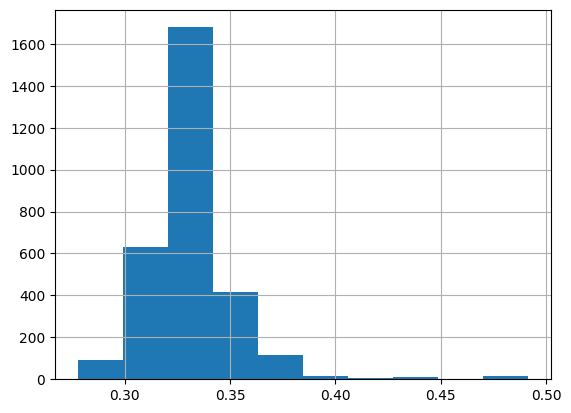

In [27]:
pd.DataFrame({'rank': proba[:,1]})['rank'].hist()

# Retrieve

works only in local mode

for running search engine

```shell
make run-search
```

In [ ]:
from utils import search, get_auth, load_config

def get_search_results(query, num=30):
    index_config = load_config()
    index_name = index_config['name']
    
    auth_config = get_auth(env_path=os.environ['ENV_PATH'])
    res = search(index_name, query, conf=auth_config, limit=num)
    candidates = [i['_source'] for i in res['hits']['hits']][:num]
    candidates = [{'content': i['content'], 'asin': i['asin']} for i in candidates]
    print(f'Num candidates: {len(candidates)}')
    return candidates

res = get_search_results('cough')
print('First candidate:\n')
print(res[0])

# RAG pipeline

In [20]:
from llm import recs_generation, get_gemini_client, generate_gemini

gemini_client = get_gemini_client(env_path=os.environ['ENV_PATH'])
print(gemini_client)

ENV loaded from /Users/adzhumurat/PycharmProjects/ai_product_engineer/.env: True


In [21]:
from llm import recs_generation, get_gemini_client, generate_gemini

candidates = get_search_results('headache tablets', num=30)
candidates = '\n'.join(["item_id: %s; review: %s" % (i['asin'], i['content']) for i in candidates])
system_prompt = f"""
  Next rows below is an item_id reviews.
  {candidates}
  Utilize reviews to determine the best item_id.
  Avoid including actual reviews; rephrase them succinctly.
  Take in account number of reviews for same item_id and sentiment of review.
  Keep the recommendation under 50 words. Avoid starting with "Based on reviews"; opt for a more creative approach!
"""

generated_result = generate_gemini(api_client=gemini_client, user_prompt=candidates, system_prompt=system_prompt, model='gemini-2.5-flash-lite')

print(generated_result.text)

ENV loaded from /Users/adzhumurat/PycharmProjects/ai_product_engineer/.env: True
Num candidates: 30
For mood support and a natural approach, B0044KICZM is highly recommended. Users report significant improvement during difficult times with minimal side effects. Other items are noted for causing headaches or not meeting expectations.


# Ranking

At final stage you can pass candidates to CatBoost to improve relevance